In [1]:
import numpy as np
import pandas as pd
import os, imageio

import tensorflow.keras.metrics as tf_metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, \
                                    Conv2D, Flatten, TimeDistributed, LSTM, MaxPooling2D

import warnings
warnings.filterwarnings('ignore')

## Helper Functions

---

The following are functions I use throughout model building 

In [2]:
# modified from https://mc.ai/train-keras-model-with-large-dataset-batch-training/
def load_data(df, batch_n, batch_size, subset):
    if batch_n > 0:
        df = pd.read_csv(df, skiprows=batch_n*batch_size+1, nrows=batch_size, names=['filename', 'label'])
    else:
        df = pd.read_csv(df, skiprows=batch_n*batch_size, nrows=batch_size)
    
    frames = []
    for dir in df['filename']:
        try:
            frame_path = subset + '/' + dir + '/' + os.listdir(subset + '/' + dir)[14]
        #if 15th frame does not exist, use first frame
        except IndexError:
            frame_path = subset + '/' + dir + '/' + os.listdir(subset + '/' + dir)[0]

        frame = imageio.imread(frame_path)

        frames.append(frame)
    
    frames = np.array(frames)
    x = frames.astype('float32')
    x /= 255
    
    y = np.array(df['label'])
    #print(y)
    
    #print(f'{batch_n} passed')
    return (x, y)

def batch_generator(df, batch_size, steps, subset):
    batch_n = 1
    while True: 
        yield load_data(df, batch_n-1, batch_size, subset)
        if batch_n < steps:
            batch_n+=1
        else:
            batch_n=1

In [3]:
def build_imagenet_model(pretrained_model):

    base_model_out = pretrained_model.output

    # Add flatten layer
    base_model_out = Flatten()(base_model_out)

    # Add 2 dense layers with dropout and batch normalization
    base_model_out = Dense(1024, activation='relu')(base_model_out)
    base_model_out = Dropout(0.5)(base_model_out)
    base_model_out = BatchNormalization()(base_model_out)
    
    base_model_out = Dense(512, activation='relu')(base_model_out)
    base_model_out = Dropout(0.25)(base_model_out)
    base_model_out = BatchNormalization()(base_model_out)

    # Add final 1 neuron layer, using sigmoid activation for binary classification
    preds = Dense(1, activation='sigmoid')(base_model_out)

    # Instantiate our final model, where we specify what are the inputs and 
    # the outputs will look like
    model = Model(inputs = pretrained_model.input, outputs = preds)
    
    return model

In [4]:
metadata_train = pd.read_csv('metadata_train.csv')
metadata_train['filename'] = metadata_train['filename'].str.replace('data_30/', '')

metadata_validation = pd.read_csv('metadata_validation.csv')
metadata_validation['filename'] = metadata_validation['filename'].str.replace('train/', '')

#metadata_test = pd.read_csv('metadata_test.csv')
#metadata_test['filename'] = metadata_test['filename'].str.replace('data_30/', '')

In [17]:
# export csv files with clean filenames for batch generation
# metadata_train.to_csv('train.csv', index=False)
# metadata_validation.to_csv('validation.csv', index=False)
#metadata_test.to_csv('test.csv', index=False)

## Baseline CNN Performance using 1 frame per video

---

In [5]:
import tensorflow as tf
from tensorflow.keras import backend as K

# custom function to obtain auc metric
# https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [6]:
### Hyperparameters
EPOCHS = 30
BATCH_SIZE = 4

'''METRICS = [
      tf_metrics.TruePositives(name='tp'),
      tf_metrics.FalsePositives(name='fp'),
      tf_metrics.TrueNegatives(name='tn'),
      tf_metrics.FalseNegatives(name='fn'), 
      tf_metrics.BinaryAccuracy(name='accuracy'),
      tf_metrics.Precision(name='precision'),
      tf_metrics.Recall(name='recall'),
      tf_metrics.AUC(name='auc'),
]'''

# use ADAM optimizer with a learning rate of 0.001 and decay of 0.0001
opt = Adam(lr=0.001, decay = 0.0001)

In [7]:
# set weights for each class to reflect their imbalance
real, fake = np.bincount(metadata_train['label'])
total = real + fake

weight_real = (1 / real)*(total)/2.0 
weight_fake = (1 / fake)*(total)/2.0

class_weight = {0: weight_real, 1: weight_fake}
print(class_weight)

{0: 4.023775216138328, 1: 0.5709466366796156}


In [8]:
# stop training early if auc stops improving at after the first 10 epochs
early_stopping = EarlyStopping(
    monitor='auc', 
    verbose=1,
    patience=10,
    mode='max')

In [9]:
steps_train = metadata_train.shape[0]//BATCH_SIZE
steps_validation = metadata_validation.shape[0]//BATCH_SIZE
#steps_test = metadata_test.shape[0]//BATCH_SIZE

train_generator = batch_generator(
    'train.csv', BATCH_SIZE, steps_train, subset='train')

validation_generator = batch_generator(
    'validation.csv', BATCH_SIZE, steps_validation, subset='validation')

#test_generator = batch_generator(
#    'test.csv', BATCH_SIZE, steps_test, subset='test')

### CNN from scratch

---

In [22]:
# fewer convolutions can result in tensor sizes that can exceed GPU memory
my_cnn = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(160, 160, 3)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

my_cnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy', auc])

my_cnn_history = my_cnn.fit_generator(
    train_generator, epochs=EPOCHS, steps_per_epoch=steps_train,
    verbose=1, shuffle=True, 
    validation_data=validation_generator, 
    validation_steps=steps_validation,
    class_weight=class_weight)

Epoch 1/30
698/698 [==============================] - 42s 60ms/step - loss: 0.7278 - binary_accuracy: 0.5190 - auc: 0.5367 - val_loss: 0.4785 - val_binary_accuracy: 0.8873 - val_auc: 0.5646
Epoch 2/30
698/698 [==============================] - 39s 56ms/step - loss: 0.6885 - binary_accuracy: 0.5587 - auc: 0.5539 - val_loss: 0.4961 - val_binary_accuracy: 0.8851 - val_auc: 0.5616
Epoch 3/30
698/698 [==============================] - 39s 56ms/step - loss: 0.6881 - binary_accuracy: 0.5462 - auc: 0.5583 - val_loss: 0.5558 - val_binary_accuracy: 0.8880 - val_auc: 0.5605
Epoch 4/30
698/698 [==============================] - 39s 56ms/step - loss: 0.6883 - binary_accuracy: 0.5419 - auc: 0.5572 - val_loss: 0.5421 - val_binary_accuracy: 0.8873 - val_auc: 0.5579
Epoch 5/30
698/698 [==============================] - 39s 57ms/step - loss: 0.6850 - binary_accuracy: 0.5713 - auc: 0.5568 - val_loss: 0.5617 - val_binary_accuracy: 0.8844 - val_auc: 0.5578
Epoch 6/30
698/698 [==============================

Not surprisingly, the scores are terrible! And the model does not seem to be learning at all. 

In [70]:
my_cnn.save("models/my_cnn.h5")

In [16]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 5.0)

def plot_metrics(model):
    train_accuracies = model.history.history['binary_accuracy']
    val_accuracies = model.history.history['val_binary_accuracy']
    
    train_auc = model.history.history['auc']
    val_auc = model.history.history['val_auc']
    
    n_epochs = np.arange(1, len(train_accuracies) + 1)

    plt.subplots(1,2)
    
    plt.subplot(1,2,1)
    plt.plot(n_epochs, train_accuracies, c='darkorange', label='Train')
    plt.plot(n_epochs, val_accuracies, c='darkblue', label='Validation')
    plt.plot(n_epochs, [0.88]*30, c='red', linestyle="--", label='Proportion of Fakes')
    plt.ylabel('Accuracy', fontdict={'size':16})
    plt.xlabel('Epoch', fontdict={'size':16})
    plt.axis(ymin=0, ymax=1)
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(n_epochs, train_auc, c='darkorange', label='Train')
    plt.plot(n_epochs, val_auc, c='darkblue', label='Validation')
    plt.ylabel('AUC', fontdict={'size':16})
    plt.xlabel('Epoch', fontdict={'size':16})
    plt.axis(ymin=0.5, ymax=1)
    
    plt.tight_layout(pad=3)
    plt.show()

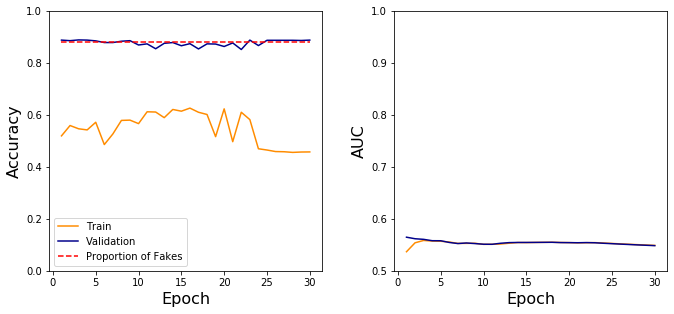

In [69]:
plot_metrics(my_cnn)

In [76]:
my_cnn_predictions_v = my_cnn.predict_generator(
    validation_generator, steps=metadata_validation.shape[0]//BATCH_SIZE, verbose=1)

346/346 [==============================] - 3s 10ms/step


In [84]:
weighted_predictions_validation

array([[0.9999975],
       [0.9999976],
       [0.9999989],
       ...,
       [0.9999976],
       [0.9999989],
       [0.9999976]], dtype=float32)

### Pre-trained Deep ImageNet Models

---

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(160, 160, 3)
)

In [11]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0         
__________

In [11]:
vgg_model = build_imagenet_model(vgg)

for layer in vgg_model.layers[:len(vgg.layers)]:
    layer.trainable = False

In [25]:
vgg_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy', auc])

NameError: name 'vgg_model' is not defined

In [13]:
vgg_history = vgg_model.fit_generator(
    train_generator, epochs=EPOCHS, steps_per_epoch=steps_train,
    verbose=1, shuffle=True, 
    validation_data=validation_generator, 
    validation_steps=steps_validation,
    class_weight=class_weight)

Epoch 1/30
698/698 [==============================] - 184s 264ms/step - loss: 0.8362 - binary_accuracy: 0.5933 - auc: 0.5702 - val_loss: 0.5273 - val_binary_accuracy: 0.7305 - val_auc: 0.6111
Epoch 2/30
698/698 [==============================] - 82s 118ms/step - loss: 0.6671 - binary_accuracy: 0.6255 - auc: 0.6182 - val_loss: 1.1364 - val_binary_accuracy: 0.4603 - val_auc: 0.6259
Epoch 3/30
698/698 [==============================] - 83s 119ms/step - loss: 0.6663 - binary_accuracy: 0.6143 - auc: 0.6262 - val_loss: 1.1153 - val_binary_accuracy: 0.3663 - val_auc: 0.6291
Epoch 4/30
698/698 [==============================] - 83s 119ms/step - loss: 0.6507 - binary_accuracy: 0.6408 - auc: 0.6306 - val_loss: 1.2206 - val_binary_accuracy: 0.4053 - val_auc: 0.6350
Epoch 5/30
698/698 [==============================] - 83s 119ms/step - loss: 0.6570 - binary_accuracy: 0.6338 - auc: 0.6369 - val_loss: 1.0674 - val_binary_accuracy: 0.5426 - val_auc: 0.6385
Epoch 6/30
698/698 [========================

In [42]:
model.predict_generator(validation_generator, steps=steps_per_epoch, verbose=1)

699/699 [==============================] - 63s 90ms/step


array([[0.99998784],
       [0.99999225],
       [0.99998736],
       ...,
       [0.9999951 ],
       [0.9999894 ],
       [0.9999851 ]], dtype=float32)

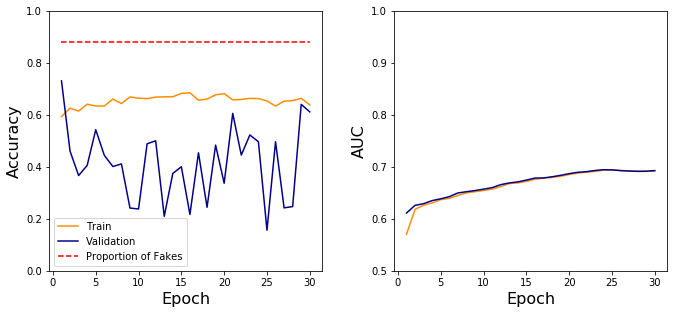

In [17]:
plot_metrics(vgg_model)

In [43]:
loss, acc = model.evaluate_generator(validation_generator, steps=steps_per_epoch, verbose=1)

699/699 [==============================] - 59s 85ms/step


In [14]:
vgg_model.save("models/vgg16.h5")

In [15]:
from tensorflow.keras.applications.xception import Xception

xception = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(160, 160, 3)
)

xception_model = build_imagenet_model(xception)

for layer in xception_model.layers[:]:
    layer.trainable = False

'''for layer in xception_model.layers[:len(xception.layers)]:
    layer.trainable = False'''

'for layer in xception_model.layers[:len(xception.layers)]:\n    layer.trainable = False'

In [16]:
#opt = Adam(lr=0.01, decay = 0.001)
xception_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy', auc])

ResourceExhaustedError: OOM when allocating tensor with shape[51200,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: dense_3/kernel/Assign = AssignVariableOp[_grappler_relax_allocator_constraints=true, dtype=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_3/kernel, dense_3/kernel/Initializer/random_uniform)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'dense_3/kernel/Assign', defined at:
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel\kernelapp.py", line 583, in start
    self.io_loop.start()
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\asyncio\base_events.py", line 442, in run_forever
    self._run_once()
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\asyncio\base_events.py", line 1462, in _run_once
    handle._run()
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel\ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\IPython\core\interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\IPython\core\interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\IPython\core\interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\IPython\core\interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-f8980de1000f>", line 9, in <module>
    xception_model = build_imagenet_model(xception)
  File "<ipython-input-3-01b3b18119df>", line 9, in build_imagenet_model
    base_model_out = Dense(1024, activation='relu')(base_model_out)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 696, in __call__
    self.build(input_shapes)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\keras\layers\core.py", line 891, in build
    trainable=True)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 460, in add_variable
    return self.add_weight(*args, **kwargs)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 534, in add_weight
    use_resource=use_resource)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\training\checkpointable\base.py", line 497, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1873, in make_variable
    use_resource=use_resource)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2234, in variable
    use_resource=use_resource)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2224, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2196, in default_variable_creator
    constraint=constraint)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 312, in __init__
    constraint=constraint)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 478, in _init_from_args
    name=n))
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\ops\gen_resource_variable_ops.py", line 156, in assign_variable_op
    "AssignVariableOp", resource=resource, value=value, name=name)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\framework\ops.py", line 3414, in create_op
    op_def=op_def)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\framework\ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[51200,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: dense_3/kernel/Assign = AssignVariableOp[_grappler_relax_allocator_constraints=true, dtype=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_3/kernel, dense_3/kernel/Initializer/random_uniform)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [13]:
xception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 79, 79, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 79, 79, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [14]:
xception_history = xception_model.fit_generator(
    train_generator, epochs=EPOCHS, steps_per_epoch=steps_train,
    verbose=1, shuffle=True, 
    validation_data=validation_generator, 
    validation_steps=steps_validation,
    class_weight=class_weight)

Epoch 1/30


ResourceExhaustedError: OOM when allocating tensor with shape[4,64,77,77] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: block1_conv2/Conv2D = Conv2D[T=DT_FLOAT, _class=["loc:@block1_conv2_bn/cond/FusedBatchNorm_1/Switch"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](block1_conv1_act/Relu, block1_conv2/Conv2D/ReadVariableOp)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: metrics/auc/Mean/_1801 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_3180_metrics/auc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [24]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15043024127113459527,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1431348428
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 390588914503056102
 physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [29]:
xception_model.save("models/xception.h5") # rerun

In [36]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(160, 160, 3)
)

inception_model = build_imagenet_model(inception)

for layer in inception_model.layers[:len(inception.layers)]:
    layer.trainable = False

In [37]:
inception_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy', auc])

In [38]:
inception_model.fit_generator(
    train_generator, epochs=EPOCHS, steps_per_epoch=steps_train,
    verbose=1, shuffle=True, 
    validation_data=validation_generator, 
    validation_steps=steps_validation,
    class_weight=class_weight)

Epoch 1/30


ResourceExhaustedError: OOM when allocating tensor with shape[18432,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_4/Adam/Variable_10/Assign = AssignVariableOp[_grappler_relax_allocator_constraints=true, dtype=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_4/Adam/Variable_10, training_4/Adam/zeros)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training_4/Adam/Variable_10/Assign', defined at:
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel\kernelapp.py", line 583, in start
    self.io_loop.start()
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\asyncio\base_events.py", line 442, in run_forever
    self._run_once()
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\asyncio\base_events.py", line 1462, in _run_once
    handle._run()
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel\ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\IPython\core\interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\IPython\core\interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\IPython\core\interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\IPython\core\interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-8428a35c6ae8>", line 6, in <module>
    class_weight=class_weight)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1761, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\keras\engine\training_generator.py", line 190, in fit_generator
    x, y, sample_weight=sample_weight, class_weight=class_weight)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1536, in train_on_batch
    self._make_train_function()
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\keras\engine\training.py", line 588, in _make_train_function
    params=self._collected_trainable_weights, loss=self.total_loss)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\keras\optimizers.py", line 503, in get_updates
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\keras\optimizers.py", line 503, in <listcomp>
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\keras\backend.py", line 970, in zeros
    return variable(v, dtype=dtype, name=name)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\keras\backend.py", line 647, in variable
    constraint=constraint)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 312, in __init__
    constraint=constraint)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 478, in _init_from_args
    name=n))
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\ops\gen_resource_variable_ops.py", line 156, in assign_variable_op
    "AssignVariableOp", resource=resource, value=value, name=name)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\framework\ops.py", line 3414, in create_op
    op_def=op_def)
  File "C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\tensorflow\python\framework\ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[18432,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_4/Adam/Variable_10/Assign = AssignVariableOp[_grappler_relax_allocator_constraints=true, dtype=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_4/Adam/Variable_10, training_4/Adam/zeros)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
inception_model.save("models/inception.h5")

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG19

vgg19 = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(160, 160, 3)
)

In [ ]:
vgg19_model = build_imagenet_model(vgg19)

for layer in vgg_model.layers[:len(vgg.layers)]:
    layer.trainable = False

In [19]:
from tensorflow.keras.applications.resnet50 import ResNet50

resnet = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(160, 160, 3)
)

resnet_model = build_imagenet_model(resnet)

for layer in resnet_model.layers[:]:
    layer.trainable = False

ValueError: Input size must be at least 197x197; got `input_shape=(160, 160, 3)`

### TimeDistributed CNN with LSTM

In [ ]:
# 3D convolution will merge frames together, which may not be desirable.
# https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00

---

In [16]:
num_classes = 2

model = Sequential()

model.add(
    TimeDistributed(vgg)()
)

model.add(
    TimeDistributed(
        Flatten()
    )
)

model.add(LSTM(256, activation='relu', return_sequences=False))

model.add(Dense(64, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(num_classes, activation='softmax'))

AttributeError: 'tuple' object has no attribute 'as_list'

In [8]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

In [15]:
model._layers

In [ ]:
X_train = a
y_train = np.array([0, 1])

In [15]:
model.fit(X_train, y_train, epochs = 2, verbose = 1)

Epoch 1/2
2/2 [==============================] - 14s 7s/step - loss: 0.6726 - acc: 1.0000
Epoch 2/2
2/2 [==============================] - 9s 5s/step - loss: 1.1921e-07 - acc: 1.0000


In [70]:
sample_frame = imageio.imread("data_30/aakkdgsmvl/000.png")
sample_frame2 = imageio.imread("data_30/aassnaulhq/000.png")

In [35]:
a = np.array([sample_frame, sample_frame2])

img_rows, img_cols = 160, 160

# scale pixel values to be between 0 and 1
a_scaled = a.astype('float32')
a_scaled /= 255

(2, 160, 160, 3)
(2, 160, 160, 3)


In [44]:
y_train.shape

(2,)

In [24]:
a = np.zeros(shape=(160,160,3))
a.shape

(160, 160, 3)

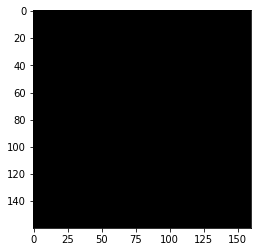

In [25]:
plt.imshow(a);
plt.show()

In [16]:
from tensorflow.keras.applications import Xception

In [17]:
model = Xception(weights='imagenet')

91889664/91884032 [==============================] - 9s 0us/step


In [18]:
model.layers

In [19]:
model.layers[-1].output

<tf.Tensor 'predictions/Softmax:0' shape=(?, 1000) dtype=float32>